In [2]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

In [3]:
# Importing required packages:

# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
%matplotlib inline

# Numba (JiT)
from numba import jit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

In [4]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [5]:
# Domain of the velocity field:
x_min, x_max = 0., 2.
y_min, y_max = 0., 1.

# Domain lengths in either direction
x_len, y_len = x_max - x_min, y_max - y_min

In [6]:
# Defining the velocity field:

@jit(nopython=True)
def _doublegyre(t,x,A,e,w):
    # a(t)
    a = e * np.sin(w*t)       
    # b(t)
    b = 1 - 2*e*np.sin(w*t)  
    # f(x,t)
    f = a*x[0,:]**2 + b*x[0,:]
    # df/dx
    dfdx = 2*a*x[0,:] + b
    
    v = np.empty(x.shape)                         
    # x-component:
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:])
    # y-component:
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*dfdx
    return v 

@jit(nopython=True)
def doublegyre_wrapper(t,x):
    # Parameters of the velocity field (Cf. Farazmand & Haller, 2012)
    # A
    A = 0.1
    # epsilon
    e = 0.1
    # omega
    w = 2*np.pi/10
    return _doublegyre(t,x,A,e,w)

In [7]:
# Function returning a grid of particles meant for plotting etc.
def grid_of_particles(Nx,Ny=None):
    if Ny is None:
        Ny = np.round(Nx*y_len/x_len).astype(int)
    
    dx = x_len/Nx
    dy = y_len/Ny
    
    x0 = (np.arange(Nx)+1./2.)*dx
    y0 = (np.arange(Ny)+1./2.)*dy
    
    y, x = np.meshgrid(y0,x0)
    
    return np.array([x,y])

# Function returning a flattened grid of particles, meant for
# advection, and only supposed to be used by
# other functions (i.e., not called directly by the user)
def _grid_of_particles_for_transport(grid):
    Nx = np.shape(grid)[1]
    Ny = np.shape(grid)[2]
    
    _grid = np.empty((2,Nx*Ny))
    
    x0 = grid[0][:,0]
    y0 = grid[1][0]
    
    for j in range(Nx):
        _grid[0,j*Ny:(j+1)*Ny] = x0[j]
        _grid[1,j*Ny:(j+1)*Ny] = y0
        
    return _grid

In [8]:
# String set containing the names of the implemented
# fixed stepsize integrators:
fixed_stepsize_integrators = set(['euler', 'rk2', 'rk3', 'rk4'])

In [9]:
# Functions advecting particles with positions defined by meshgrids [X,Y]

def endpoints(t_curr,t_end,pos_curr,h,integrator,deriv,n_proc=4,atol=None,rtol=None):
    # Flatten input meshgrids for efficiency:
    Nx = np.shape(pos_curr)[1]
    Ny = np.shape(pos_curr)[2]
    pos_curr = _grid_of_particles_for_transport(pos_curr)
    partition = np.floor(np.size(pos_curr,1)/n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    if integrator.__name__ in fixed_stepsize_integrators:
        processlist = [mp.Process(target = _endpoints_fixed_slice,
                             args=(t_curr,t_end,
                                  pos_curr[:,j*partition:np.size(pos_curr,1) if j+1 is n_proc else (j+1)*partition],
                                  h,integrator,deriv,queuelist[j])) for j in range(n_proc)]
    else:
        processlist = [mp.Process(target = _endpoints_fixed_slice,
                             args=(t_curr,t_end,
                                  pos_curr[:,j*partition:np.size(pos_curr,1) if j+1 is n_proc else (j+1)*partition],
                                  h,integrator,deriv,atol,rtol,queuelist[j])) for j in range(n_proc)]
    
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        pos_curr[:,j*partition:np.size(pos_curr,1) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
        
    return pos_curr.reshape((2,Ny,Nx))
    
def _endpoints_fixed_slice(t_curr,t_end,pos_curr,h,integrator,deriv,q):
    t = t_curr
    while(t < t_end):
        h = np.minimum(h,t_end-t)
        t, pos_curr, h = integrator(t,pos_curr,h,deriv)
    q.put(pos_curr)
    
def _endpoints_adaptive_slice(t_curr,t_end,pos_curr,h,integrator,deriv,atol,rtol,q):
    h = np.ones(np.size(pos_curr,1))*h
    t = np.ones(np.size(pos_curr,1))*t_curr
    while(np.any(t < t_end)):
        h = np.minimum(h,t_end-t)
        t, pos_curr, h = integrator(t,pos_curr,h,deriv,atol,rtol)
    q.put(pos_curr)       

# Step 0: Check that the advection works (as expected)

In [ ]:
from numerical_integrators.singlestep import rk2
Nx = 200
Ny = 100

pos_init = grid_of_particles(Nx,Ny)

t_curr = 0.
t_max = 20.
dt = 0.01

pos_end = endpoints(t_curr,t_max,pos_init,h=dt,integrator=rk2,deriv=doublegyre_wrapper)

plt.figure(figsize=(12,8),dpi=80)
plt.scatter(pos_end[0],pos_end[1],s=2,lw=0)
plt.title(r'RK2 advected grid of initial particles, $Nx={}$, $Ny={}$, $\Delta t={}$, $T={}$'.format(Nx,Ny,dt,t_max))

# Step 1: Define functions which return eigenvalues and -vectors of strain tensors (i.e., characteristics)

In [10]:
# Function that takes the initial time, end time, integration step
# and initial positions (meshgrids) as inputs, returning
# the computed eigenvalues and eigenvectors of the strain tensors
# at the end time
def characteristics(t_curr,t_end,pos_curr,h,integrator,rhs,n_proc=4,atol=1.e-6,rtol=1.e-9):
    # If the advection has already been performed previously, load saved state
    
    # For fixed step integrators, the tolerance plays no role, and its value is thus not
    # stored in the file names; similarly, the (initial) step length plays no _real_
    # role for adaptive step size integrators, and is thus not stored in file names.
    
    dx = pos_curr[0,1,0]-pos_curr[0,0,0]
    dy = pos_curr[1,0,1]-pos_curr[1,0,0]
    
    deltax = np.minimum(1e-5,dx*1e-2)
    deltay = np.minimum(1e-5,dy*1e-2)
    
    try: 
        if integrator.__name__ in fixed_stepsize_integrators:
            lambda1 = np.load('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
            lambda2 = np.load('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
            xi1 = np.load('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
            xi2 = np.load('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
        else:
            lambda1 = np.load('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol))
            lambda2 = np.load('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol.rtol))
            xi1 = np.load('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol))
            xi2 = np.load('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol))
        print('Precomputed characteristics found! Advection not necessary in this case.')
    except IOError:
        tic = time.time()
        print('Precomputed characteristics not found! Please wait!')
        lambda1, lambda2, xi1, xi2 = _characteristics(t_curr,t_end,pos_curr,h,integrator,rhs,dx,dy,deltax,deltay,n_proc,atol,rtol)

        toc = time.time()
        
        print('Advection etc. was necessary, time elapsed: {} seconds'.format(toc-tic))
        
        if integrator.__name__ in fixed_stepsize_integrators:
            np.save('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), lambda1)
            np.save('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), lambda2)
            np.save('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), xi1)
            np.save('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), xi2)
            
        else:
            np.save('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), lambda1)
            np.save('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), lambda2)
            np.save('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), xi1)
            np.save('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), xi2)
        
        print('Characteristics now stored. Advection will not be necessary the next time the same parameters are used!')
        
    return lambda1, lambda2, xi1, xi2
        
def _characteristics(t_curr,t_end,pos_curr,h,integrator,rhs,dx,dy,deltax,deltay,n_proc,atol,rtol):
    # Advect main and auxiliary grid points:
    grid_end = _endpoints_grid(t_curr,t_end,np.array([_grid_of_particles_for_transport(pos_curr),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([deltax,0]).reshape(2,1),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([0,deltay]).reshape(2,1),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([-deltax,0]).reshape(2,1),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([0,-deltay]).reshape(2,1)]),
                                h,integrator,rhs,n_proc,atol,rtol)
    pos_main = grid_end[0,:,:].reshape(np.shape(pos_curr))
    pos_right = grid_end[1,:,:].reshape(np.shape(pos_curr))
    pos_top = grid_end[2,:,:].reshape(np.shape(pos_curr))
    pos_left = grid_end[3,:,:].reshape(np.shape(pos_curr))
    pos_beneath = grid_end[4,:,:].reshape(np.shape(pos_curr))
    
    main_tensor, auxiliary_tensor = _find_strain_tensors(pos_main,pos_right,pos_top,pos_left,pos_beneath,dx,dy,deltax,deltay)
    
    lambda1, lambda2, xi1, xi2 = _find_characteristics(main_tensor,auxiliary_tensor)
    
    return lambda1, lambda2, xi1, xi2

def _endpoints_grid(t_curr,t_end,pos_curr,h,integrator,rhs,n_proc,atol,rtol):
    partition = np.floor(np.size(pos_curr,2)/n_proc).astype(int)
    queuelist = [mp.Queue() for j in range(n_proc)]
    if integrator.__name__ in fixed_stepsize_integrators:
        processlist = [mp.Process(target=_endpoints_grid_fixed_slice,
                                 args=(t_curr,t_end,
                                      pos_curr[:,:,j*partition:np.size(pos_curr,2) if j+1 is n_proc else (j+1)*partition],
                                      h,integrator,rhs,queuelist[j])) for j in range(n_proc)]
    else:
        processlist = [mp.Process(target=_endpoints_adaptive_slice,
                                 args=(t_curr,t_end,
                                      pos_curr[:,:,j*partition:np.size(pos_curr,2) if j+1 is n_proc else (j+1)*partition],
                                      h,integrator,rhs,atol,rtol,queuelist[j])) for j in range(n_proc)]
        
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        pos_curr[:,:,j*partition:np.size(pos_curr,2) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
    
    return pos_curr

def _endpoints_grid_fixed_slice(t_curr,t_end,pos_curr,h,integrator,rhs,q):
    for j in range(5):
        stride = np.copy(h)
        t = np.copy(t_curr)
        while (t<t_end):
            stride = np.minimum(stride,t_end-t)
            t,pos_curr[j,:,:],stride = integrator(t,pos_curr[j,:,:],stride,rhs)        
    q.put(pos_curr)
    
def _endpoints_grid_adaptive_slice(t_curr,t_end,pos_curr,h,integrator,rhs,atol,rtol,q):
    for j in range(5):
        stride = np.ones(np.size(pos_curr,2))*h
        t = np.ones(np.size(pos_curr,2))*t_curr
        while (np.any(t<t_end)):
            stride = np.minimum(stride,t_end-t)
            t,pos_curr[j,:,:],stride = integrator(t,pos_curr[j,:,:],stride,rhs,atol=atol,rtol=rtol)        
    q.put(pos_curr)
    
def _find_strain_tensors(pos_main,pos_right,pos_above,pos_left,pos_beneath,dx,dy,deltax,deltay):
    # Find Jacobian of auxiliary grid:
    dF_a = np.empty((2,2,np.size(pos_main,1),np.size(pos_main,2)))
    
    # Centered differencing throughout:
    # dx/dx
    dF_a[0,0,:,:] = (pos_right[0]-pos_left[0])/(2*deltax)
    # dx/dy
    dF_a[0,1,:,:] = (pos_above[0]-pos_beneath[0])/(2*deltay)
    # dy/dx
    dF_a[1,0,:,:] = (pos_right[1]-pos_left[1])/(2*deltax)
    # dy/dy
    dF_a[1,1,:,:] = (pos_above[1]-pos_beneath[1])/(2*deltay)
    
    # Find Jacobian of main grid:
    dF = np.empty(np.shape(dF_a))
    
    # dx/dx
    # Centered differences for the interior points:
    dF[0,0,1:-1,:] = (pos_main[0,2:,:]-pos_main[0,0:-2,:])/(2*dx)
    # Second order accurate forwards / backwards difference for the edges:
    dF[0,0,0,:]  = (-3*pos_main[0,0,:]+4*pos_main[0,1,:]-2*pos_main[0,2,:])/(2*dx)
    dF[0,0,-1,:] = (3*pos_main[0,-1,:]-4*pos_main[0,-2,:]+2*pos_main[0,-3,:])/(2*dx)
    
    # dx/dy
    # Centered differences for the interior points:
    dF[0,1,:,1:-1] = (pos_main[0,:,2:]-pos_main[0,:,0:-2])/(2*dy) 
    # Second order accurate forwards / backwards difference for the edges:
    dF[0,1,:,0]  = (-3*pos_main[0,:,0]+4*pos_main[0,:,1]-2*pos_main[0,:,2])/(2*dy)
    dF[0,1,:,-1] = (3*pos_main[0,:,-1]-4*pos_main[0,:,-2]+2*pos_main[0,:,-3])/(2*dy)
    
    # dy/dx
    # Centered differences for the interior points:
    dF[1,0,1:-1,:] = (pos_main[1,2:,:]-pos_main[1,0:-2,:])/(2*dx)
    # Second order accurate forwards / backwards difference for the edges:
    dF[1,0,0,:]  = (-3*pos_main[1,0,:]+4*pos_main[1,1,:]-2*pos_main[1,2,:])/(2*dx) 
    dF[1,0,-1,:] = (3*pos_main[1,-1,:]-4*pos_main[1,-2,:]+2*pos_main[1,-3,:])/(2*dx)
    
    # dy/dy
    # Centered differences for the interior points:
    dF[1,1,:,1:-1] = (pos_main[1,:,2:]-pos_main[1,:,0:-2])/(2*dy)  
    # Second order accurate forwards / backwards difference for the edges:
    dF[1,1,:,0]  = (-3*pos_main[1,:,0]+4*pos_main[1,:,1]-2*pos_main[1,:,2])/(2*dy)
    dF[1,1,:,-1] = (3*pos_main[1,:,-1]-4*pos_main[1,:,-2]+2*pos_main[1,:,-3])/(2*dy)
    
    # Allocate the strain tensors:
    C = np.empty(np.shape(dF))
    C_a = np.empty(np.shape(dF_a))
    
    # Explicitly calculate the strain tensors:
    for i in range(dF.shape[2]):
        for j in range(dF.shape[3]):
            C[:,:,i,j] = np.dot(dF[:,:,i,j].T,dF[:,:,i,j])
            C_a[:,:,i,j] = np.dot(dF_a[:,:,i,j].T,dF_a[:,:,i,j])
            
    return C, C_a

def _find_characteristics(main_tensor,auxiliary_tensor):
    lambda1 = np.empty((main_tensor.shape[2],main_tensor.shape[3]))
    lambda2 = np.empty(lambda1.shape)
    xi1 = np.empty((2,lambda1.shape[0],lambda1.shape[1]))
    xi2 = np.empty(xi1.shape)
    
    for i in range(lambda1.shape[0]):
        for j in range(lambda1.shape[1]):
            values, vectors = np.linalg.eigh(main_tensor[:,:,i,j])
            values_a, vectors_a = np.linalg.eigh(auxiliary_tensor[:,:,i,j])
            
            # Linalg.eigh returns the eigenvalues sorted in ascending order
            # wrt magnitude, and similarly for the corresponding eigenvectors
            
            lambda1[i,j] = values[0]
            lambda2[i,j] = values[1]
            
            xi1[:,i,j] = vectors_a[:,0]
            xi2[:,i,j] = vectors_a[:,1]
            
    return lambda1, lambda2, xi1, xi2
    
    
    

# Step 2: Define grid cells, time step, simulation time and integrator

## Then, calculate the eigenvectors and -values

In [11]:
from numerical_integrators.singlestep import rk4

integrator = rk4

# Create output directory for precomputed characteristics, if it does not already exist:
ensure_path_exists('precomputed_characteristics/{}'.format(integrator.__name__))

Nx = 1000
Ny = 500

t_min = 0.
t_max = 20.
dt = 0.01

pos_init = grid_of_particles(Nx,Ny)

lambda1, lambda2, xi1, xi2 = characteristics(t_min,t_max,pos_init,dt,integrator,doublegyre_wrapper)


Precomputed characteristics found! Advection not necessary in this case.


(0, 1)

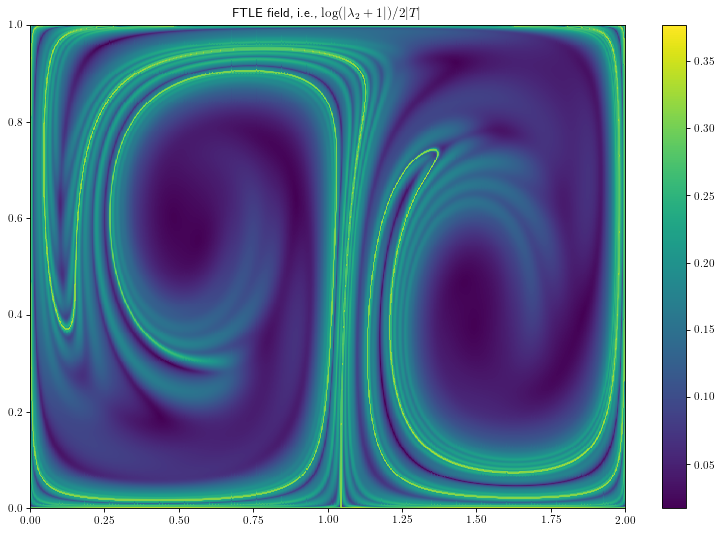

In [12]:
plt.figure(figsize=(12,8),dpi=80)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(np.abs(lambda2)+1)/(2*np.abs(t_max)))
plt.colorbar()
plt.title(r'FTLE field, i.e., $\log(|\lambda_{2} + 1|) / 2|T|$')
plt.xlim(0,2)
plt.ylim(0,1)

# Step 3: Define functions returning masks for the ICs satisfying (A) and (B):

## (A): $\lambda_{1}(\mathbf{x}_{0}) \neq \lambda_{2}(\mathbf{x}_{0}) > 1 $
## (B): $\langle \mathbf{\xi}_{2}(\mathbf{x}_{0}), \nabla^{2} \lambda_2(\mathbf{x}_0) \mathbf{\xi}_2(\mathbf{x}_0) \rangle \leq 0$

In [13]:
def a_true(lambda1, lambda2):
    return np.logical_and(lambda1<lambda2,lambda2>1)

# When interpreting (B) as the Laplacian of just the eigenvalue:
def b_true(lambda2, xi2):
    return np.less_equal(np.sum(xi2*_laplacian_eigenvalue(lambda2)*xi2,axis=0),0)

def _laplacian_eigenvalue(lambda_):
    Nx = np.size(lambda_,0)
    Ny = np.size(lambda_,1)
    
    dx = x_len/Nx
    dy = y_len/Ny
    
    lapl = np.empty((Nx,Ny))
    
    # First direction:
    # Use centered differencing for internal points
    lapl[1:-1,:] = (lambda_[2:,:]-2*lambda_[1:-1,:]+lambda_[0:-2,:])/(dx**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl[0,:] = (2*lambda_[0,:]-5*lambda_[1,:]+4*lambda_[2,:]-lambda_[3,:])/(dx**2)
    lapl[-1,:] = (2*lambda_[-1,:]-5*lambda_[-2,:]+4*lambda_[-3,:]-lambda_[-4,:])/(dx**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl[:,1:-1] += (lambda_[:,2:]-2*lambda_[:,1:-1]+lambda_[:,0:-2])/(dy**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl[:,0] += (2*lambda_[:,0]-5*lambda_[:,1]+4*lambda_[:,2]-lambda_[:,3])/(dy**2)
    lapl[:,-1] += (2*lambda_[:,-1]-5*lambda_[:,-2]+4*lambda_[:,-3]-lambda_[:,-4])/(dy**2)
    
    return lapl

# When interpreting (B) as the Laplacian of the eigenvalue-eigenvector product:
def b_true2(lambda2,xi2):
    return np.less_equal(np.sum(xi2*_laplacian_eigenvalue_eigenvector_product(lambda2,xi2),axis=0),0)

def _laplacian_eigenvalue_eigenvector_product(lambda_,xi_):
    Nx = np.size(lambda_,0)
    Ny = np.size(lambda_,1)
    
    dx = x_len/Nx
    dy = y_len/Ny
    
    lapl = np.empty((2,Nx,Ny))
    
    # First direction: Use centered differencing for internal points
    lapl[:,1:-1,:] = (lambda_[2:,:]*xi_[:,2:,:]-2*lambda_[1:-1,:]*xi_[:,1:-1,:]+lambda_[0:-2,:]*xi_[:,0:-2,:])/(dx**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl[:,0,:] = (2*lambda_[0,:]*xi_[:,0,:]-5*lambda_[1,:]*xi_[:,1,:]+4*lambda_[2,:]*xi_[:,2,:]-lambda_[3,:]*xi_[:,3,:])/(dx**2)
    lapl[:,-1,:] = (2*lambda_[-1,:]*xi_[:,-1,:]-5*lambda_[-2,:]*xi_[:,-2,:]+4*lambda_[-3,:]*xi_[:,-3,:]-lambda_[-4,:]*xi_[:,-4,:])/(dx**2)
    
    # Second direction: Use centered differencing for internal points
    lapl[:,:,1:-1] += (lambda_[:,2:]*xi_[:,:,2:]-2*lambda_[:,1:-1]*xi_[:,:,1:-1]+lambda_[:,0:-2]*xi_[:,:,0:-2])/(dy**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl[:,:,0] += (2*lambda_[:,0]*xi_[:,:,0]-5*lambda_[:,1]*xi_[:,:,1]+4*lambda_[:,2]*xi_[:,:,2]-lambda_[:,3]*xi_[:,:,3])/(dy**2)
    lapl[:,:,-1] += (2*lambda_[:,-1]*xi_[:,:,-1]-5*lambda_[:,-2]*xi_[:,:,-2]+4*lambda_[:,-3]*xi_[:,:,-3]-lambda_[:,-4]*xi_[:,:,-4])/(dy**2)
    
    return lapl

# Step 4: Find the domains for which conditions (A) and (B) hold

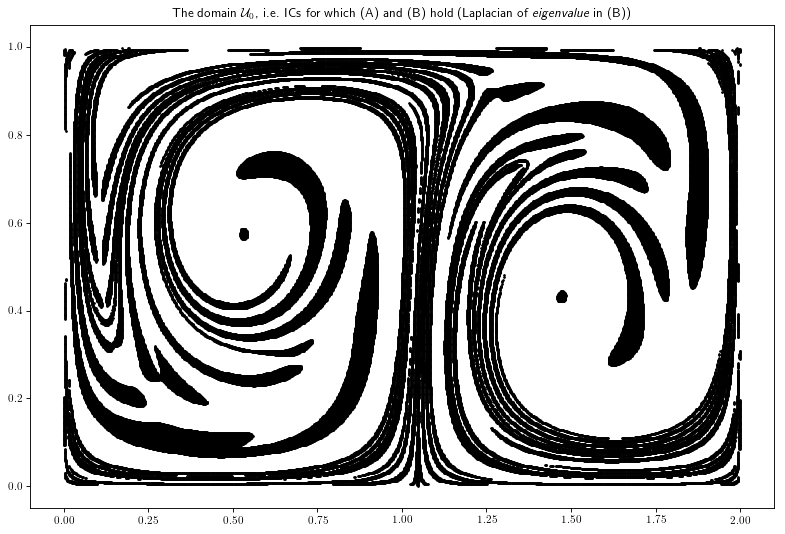

In [14]:
mask_a = a_true(lambda1,lambda2)
mask_b = b_true(lambda2,xi2)
plt.figure(figsize=(12,8),dpi=80)
plt.scatter(pos_init[0,np.logical_and(mask_a,mask_b)],pos_init[1,np.logical_and(mask_a,mask_b)],s=2,c='k')
plt.title(r'The domain $\mathcal{U}_{0}$, i.e. ICs for which (A) and (B) hold (Laplacian of \emph{eigenvalue} in (B))')

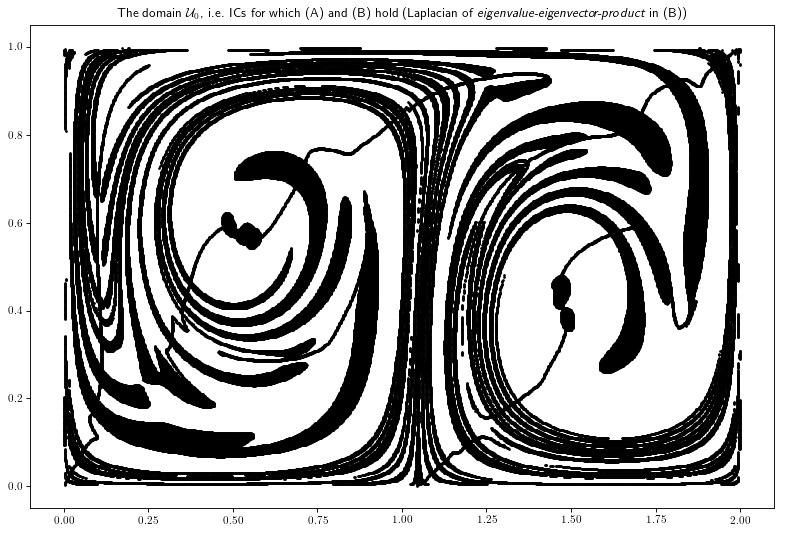

In [15]:
mask_a = a_true(lambda1,lambda2)
mask_b2 = b_true2(lambda2,xi2)
plt.figure(figsize=(12,8),dpi=80)
plt.scatter(pos_init[0,np.logical_and(mask_a,mask_b2)],pos_init[1,np.logical_and(mask_a,mask_b2)],s=2,c='k')
plt.title(r'The domain $\mathcal{U}_{0}$, i.e. ICs for which (A) and (B) hold (Laplacian of \emph{eigenvalue-eigenvector-product} in (B))')

# Step 5: Define functions to choose $\mathcal{G}_{0}$ as the intersection             between $\mathcal{U}_{0}$ and a set of vertical and horizontal lines

In [16]:
def find_g0(pos_init,num_horz_lines,num_vert_lines):
    Nx = np.size(pos_init,1)
    Ny = np.size(pos_init,2)
    
    mask = np.zeros((Nx,Ny),dtype=np.bool)
    
    stride_horz = np.floor(Ny/(num_vert_lines+1)).astype(int)
    stride_vert = np.floor(Nx/(num_horz_lines+1)).astype(int)
    
    for j in range(1,num_vert_lines+1):
        mask[:,np.minimum(j*stride_horz,Ny-1)] = True
    
    for j in range(1,num_horz_lines+1):
        mask[np.minimum(j*stride_vert,Nx-1),:] = True
        
    return mask

# Step 6: Choose $\mathcal{G}_{0}$ by setting the number of vertical and horizontal lines

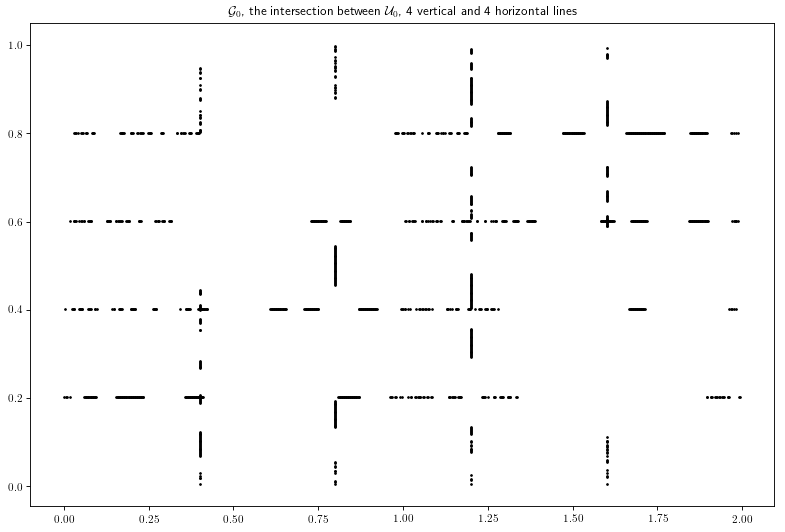

In [17]:
num_horz_lines = 4
num_vert_lines = 4
mask_g0 = find_g0(pos_init,num_horz_lines,num_vert_lines)

g0 = pos_init[:,np.logical_and(np.logical_and(mask_a,mask_b),mask_g0)]

plt.figure(figsize=(12,8),dpi=80)
plt.scatter(g0[0],g0[1],s=2,c='k')
plt.title(r'$\mathcal{G}_{0}$, the intersection between $\mathcal{U}_{0}$, %i vertical and %i horizontal lines' %(num_vert_lines,num_horz_lines) )

# Step 7: Define necessary functions and classes to advect the points in $\mathcal{G}_{0}$

In [18]:
class InABDomain:
    def __init__(self,pos_init,mask_a,mask_b,thresh=0.5):
        self.inAB_domain_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],np.logical_and(mask_a,mask_b).T)
        self.thresh = thresh
        
    def __call__(self,pos):
        return self.inAB_domain_spline.ev(pos[1],pos[0]) > self.thresh
    
class InNumericalDomain:
    def __init__(self,x_min,x_max,y_min,y_max,padding_factor=0.):
        self._x_min = x_min-(x_max-x_min)*padding_factor
        self._x_max = x_max+(x_max-x_min)*padding_factor
        self._y_min = y_min-(y_max-y_min)*padding_factor
        self._y_max = y_max+(y_max-y_min)*padding_factor
    
    def __call__(self,pos):
        return pos[0] >= self._x_min and pos[0] <= self._x_max and pos[1] >= self._y_min and pos[1] <= self._y_max
    
class RescaledSplinedDerivative:
    def __init__(self,pos_init,lambda1,lambda2,xi1,x_min,x_max,y_min,y_max,padding_factor=0.):
        self._lambda1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lambda1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor])
        self._lambda2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lambda2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor])
        self._xi1_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi1[0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor])
        self._xi1_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi1[1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor])
        self._prev = None
        
    def set_previous(self,prev):
        self._prev = prev
        
    def _alpha(self,t,pos):
        lambda1 = self._lambda1_spline.ev(pos[1],pos[0])
        lambda2 = self._lambda2_spline.ev(pos[1],pos[0])
        
        return ((lambda1-lambda2)/(lambda1+lambda2))**2
    
    def _normalize(self,xi1_x,xi1_y):
        norm = np.sqrt(xi1_x**2+xi1_y**2)
        return xi1_x/norm, xi1_y/norm
        
    def __call__(self,t,pos):
        lambda1 = self._lambda1_spline.ev(pos[1],pos[0])
        lambda2 = self._lambda2_spline.ev(pos[1],pos[0])
        alpha = self._alpha(t,pos)
        xi1_x = self._xi1_x_spline.ev(pos[1],pos[0])
        xi1_y = self._xi1_y_spline.ev(pos[1],pos[0])
        
        xi1_x, xi1_y = self._normalize(xi1_x,xi1_y)
        
        new = alpha*np.array([xi1_x,xi1_y])
        
        if self._prev is None:
            sign = 1
        else:
            sign = np.sign(np.dot(self._prev,new))
        
        return sign*new
    
        
    
class Strainline:
    def __init__(self,startpoint,pos_init,lambda1_spline,lambda2_spline,l_min,l_f_max):
        self._pos = [startpoint.T]
        self._lambda1_spline = lambda1_spline
        self._lambda2_spline = lambda2_spline
        self._length = 0.
        self._minimum_length = l_min
        self._sufficient_length = False
        self._maximum_continious_failure_length = l_f_max
        self._continious_failure_length = 0.
        self._continious_failure = False
        self._stationary_endpoint = False
        self._num_points = 1
    
    def current_alpha(self):
        lambda1 = self._lambda1_spline.ev(self.current_position()[1], self.current_position()[0])
        lambda2 = self._lambda2_spline.ev(self.current_position()[1], self.current_position()[0])
        return ((lambda1-lambda2)/(lambda1+lambda2))**2
    
    def current_position(self):
        return np.asarray(self._pos[-1])
    
    def long_enough(self):
        return self._sufficient_length
    
    def is_long_enough(self):
        self._sufficient_length = True
    
    def has_failed_continiously(self):
        return self._continious_failure
    
    def failed_continiously(self):
        self._continious_failure = True
    
    def set_continious_failure_length(self,length):
        self._continious_failure_length = length
    
    def reached_stationary_point(self):
        return self._stationary_endpoint
    
    def get_length(self):
        return self._length
    
    def get_continious_failure_length(self):
        return self._continious_failure_length
    
    def get_num_points(self):
        return self._num_points
    
    def set_length(self,length):
        self._length = length
        
    def append(self,pos):
        self._pos.append(pos.T)
        self._num_points += 1
        
    def average_lambda2(self):
        return np.mean(self._lambda2_spline.ev(self.entire_trajectory()[1],self.entire_trajectory()[0]))
    
    def entire_trajectory(self):
        return np.asarray(self._pos)
    
    def _merge(self,other):
        pos_right = other._pos
        self._pos = self._pos[::-1].T
        self._pos.append(other._pos[1:].T)
        self._num_points = self._num_points + other._num_points - 1
        self._length = self._length + other._length
        self._sufficient_length = self._length > self._minimum_length
        self._continious_failure = self._continious_failure or other._continious_failure
        self._stationary_endpoint = self._stationary_endpoint or other._stationary_endpoint
    
    
def advect_strainlines_in_parallel(pos_g0,max_iter,integrator,stride,l_f_max,l_min,tol_alpha,pos_init,lambda1,lambda2,xi1,x_min,x_max,y_min,y_max,padding_factor=0.,n_proc=4):
    in_AB_domain = InABDomain(pos_init,a_true(lambda1,lambda2),b_true(lambda1,lambda2))
    in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,padding_factor)
    
    lambda1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lambda1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor])
    lambda2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lambda2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor])
    
    rhs = RescaledSplinedDerivative(pos_init,lambda1,lambda2,xi1,x_min,x_max,y_min,y_max,padding_factor)
    
    # First, we integrate forwards
    # Container for all strainlines
    strainlines_forwards = [Strainline(pos_g0[:,j],pos_init,lambda1_spline,lambda2_spline,l_min,l_f_max) for j in range(np.size(pos_g0,1))]
    
    # Partition distributed to each process:
    partition = np.floor(np.size(pos_g0,1)/n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    processlist = [mp.Process(target=_advect_strainline_slice,
                             args=(strainlines_forwards[j*partition:np.size(strainlines_forwards,0) if j+1 is n_proc else (j+1)*partition],
                                   max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB_domain,
                                   in_numerical_domain,j,queuelist[j])) for j in range(n_proc)]
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        strainlines_forwards[j*partition:np.size(strainlines_forwards,0) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
        
    print('Forwards integration finished. Now integrating backwards:')
        
    # The, we integrate backwards:
    # Container for all strainlines
    strainlines_backwards = [Strainline(pos_g0[:,j],pos_init,lambda1_spline,lambda2_spline,l_min,l_f_max) for j in range(np.size(pos_g0,1))]

    queuelist = [mp.Queue() for j in range(n_proc)]
    # Important: Integrate with NEGATIVE stride
    processlist = [mp.Process(target=_advect_strainline_slice,
                             args=(strainlines_forwards[j*partition:np.size(strainlines_backwards,0) if j+1 is n_proc else (j+1)*partition],
                                   max_iter,rhs,integrator,-stride,l_f_max,l_min,tol_alpha,in_AB_domain,
                                   in_numerical_domain,j,queuelist[j])) for j in range(n_proc)]
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        strainlines_backwards[j*partition:np.size(strainlines_backwards,0) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
    
    #strainlines = _merge_forwards_and_backwards_parts(strainlines_backwards,strainlines_forwards)
    
    
    print('Backwards integration also finished. Results concatenated.')
    
    
    return strainlines_backwards,strainlines_forwards

def _advect_strainline_slice(strainlines,max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB,in_domain,pn,q):
    for count, strainline in enumerate(strainlines):
        rhs.set_previous(None)
        t = 0.
        iteration = 0
        L = 0.
        L_f = 0.
        rhs.set_previous(rhs(t,strainline.current_position()))
        prev_rhs = rhs(t,strainline.current_position())
        t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        iteration+=1
        #print(pos_trial)
        #print(in_domain(pos_trial))
        while iteration<max_iter and in_domain(pos_trial) and strainline.current_alpha() > tol_alpha and not strainline.has_failed_continiously():
            if t_trial is not t:
                L += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                if not in_AB(pos_trial):
                    L_f += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                else:
                    L_f = 0.
                rhs.set_previous(prev_rhs)
                t = t_trial
                strainline.append(pos_trial)
                if L_f > l_f_max:
                    strainline.failed_continiously()
                    strainline.set_continious_failure_length(L_f)
                iteration+=1
            prev_rhs = rhs(t,strainline.current_position())
            t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        if L > l_min:
            strainline.set_length(L)
            strainline.is_long_enough()
        if strainline.current_alpha() <= tol_alpha:
            strainline.reached_stationary_point()
        if not (np.mod(count +  1 +  np.floor(np.size(strainlines,0)/4).astype(int), np.floor(np.size(strainlines,0)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
    q.put(strainlines)

def _merge_forwards_and_backwards_parts(strainlines_backwards,strainlines_forwards):
    print(len(strainlines_backwards))
    print(len(strainlines_forwards))
    #assert len(strainlines_backwards) is len(strainlines_forwards)
    for j in range(len(strainlines_backwards)):
        strainlines_backwards[j]._merge(strainlines_forwards[j])
    #strainlines_backwards._merge(strainlines_forwards)
    return strainlines_backwards
                

# Step 8: Advect the points in $\mathcal{G}_{0}$ in the (stationary) $\vec{\xi}_{1}$ field

In [19]:
max_iter = 10000
stride = 0.005
l_f_max = 0.2
l_min = 1
tol_alpha = 1.e-10

tic = time.time()
strainlines_backwards,strainlines_forwards = advect_strainlines_in_parallel(g0,max_iter,integrator,stride,l_f_max,l_min,tol_alpha,pos_init,lambda1,lambda2,xi1,x_min,x_max,y_min,y_max)
toc = time.time()

print('Elapsed time: {} seconds'.format(toc-tic))

Process 3: Finished integrating strainline candidate 84 of 338
Process 1: Finished integrating strainline candidate 84 of 338
Process 2: Finished integrating strainline candidate 84 of 338
Process 0: Finished integrating strainline candidate 84 of 338
Process 1: Finished integrating strainline candidate 168 of 338
Process 3: Finished integrating strainline candidate 168 of 338
Process 2: Finished integrating strainline candidate 168 of 338
Process 0: Finished integrating strainline candidate 168 of 338
Process 1: Finished integrating strainline candidate 252 of 338
Process 2: Finished integrating strainline candidate 252 of 338
Process 1: Finished integrating strainline candidate 336 of 338
Process 2: Finished integrating strainline candidate 336 of 338
Process 0: Finished integrating strainline candidate 252 of 338
Process 0: Finished integrating strainline candidate 336 of 338
Process 3: Finished integrating strainline candidate 252 of 338
Process 3: Finished integrating strainline c

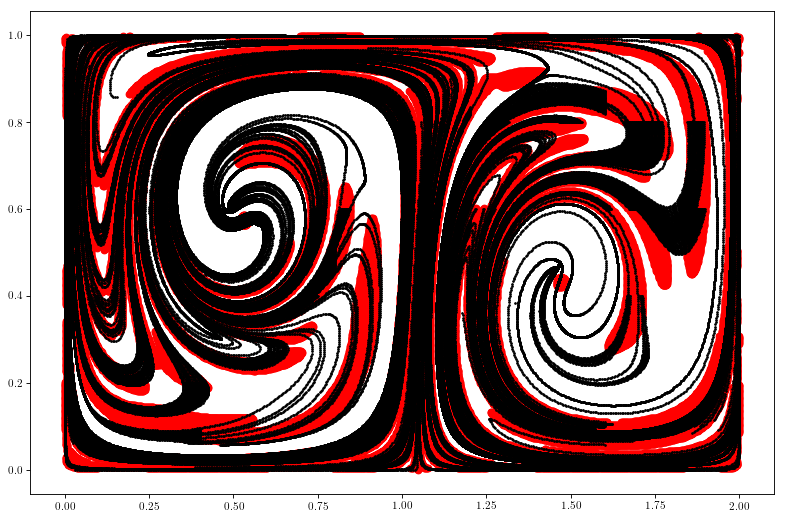

In [20]:
plt.figure(figsize=(12,8),dpi=80)
plt.scatter(pos_init[0,np.logical_and(mask_a,mask_b)], pos_init[1,np.logical_and(mask_a,mask_b)],c='r')
for strainline in strainlines_forwards:
    if strainline.long_enough(): #and not strainline.has_failed_continiously():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],s=2,c='k')
plt.show()

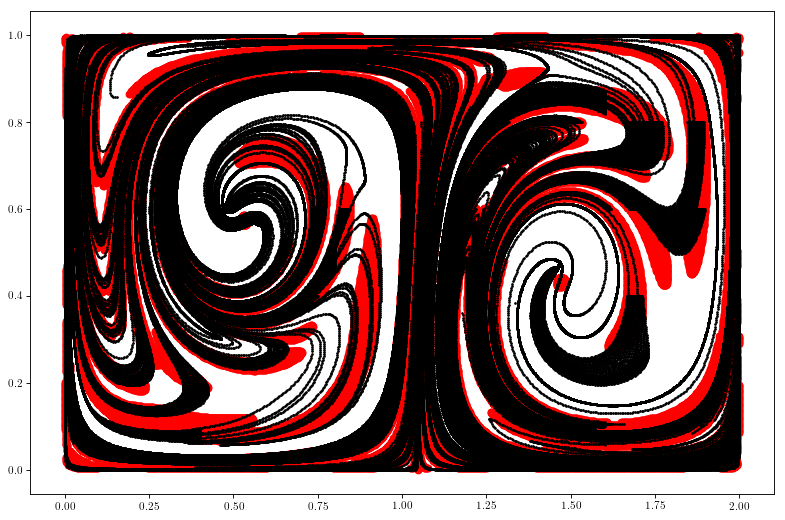

In [21]:
plt.figure(figsize=(12,8),dpi=80)
plt.scatter(pos_init[0,np.logical_and(mask_a,mask_b)], pos_init[1,np.logical_and(mask_a,mask_b)],c='r')
for strainline in strainlines_backwards:
    if strainline.long_enough(): #and not strainline.has_failed_continiously():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],s=2,c='k')
plt.show()

In [ ]:
plt.figure(figsize=(12,8),dpi=80)
plt.scatter(g0[0],g0[1])

In [ ]:
np.shape(strainlines_forwards[19].entire_trajectory()[:])

In [ ]:
np.shape(strainlines_backwards[19].entire_trajectory()[:])

In [ ]:
a

In [ ]:
b = np.copy(a[0])

In [ ]:
b

In [ ]:
b[0].long_enough

In [ ]:
assert 1 is 1

In [ ]:
strainlines

In [ ]:
strainlines[0]

In [ ]:
strainlines[1].entire_trajectory()[:,0]